In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import lib.features as features
import lib.breeds as breeds
import lib.plots as plots
import lib.models as models

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
data_folder = '../data/csv/'

# get one mouse from each line
mice = [breeds.mice_breeds[line][0] for line in breeds.mice_breeds.keys()][:15] # get 15 mice from different lines
print(f"mice: {mice}")

data_files = [mouse + ".smo.csv" for mouse in mice]
data_files_train = data_files[:-1] # TODO: change [:1] to [:-1] to train on all instead of one
data_files_test = data_files[-1:]

print(f"Training on {data_files_train}")
print(f"Testing on {data_files_test}")

days = [0]#, 1, 2, 3]
window_sizes = []#[2, 5, 10, 20, 50, 100]
window_features = ["EEGv", "EMGv"]
spectral=False # TODO: True
rolloffs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
test_size = 0.3
useRaw = False
dropBins = True
cat_matrix = True # True for neural net, any for random forest
standardize_df = False

lr=1e-4
epochs=150
batch_size=64

seed = 13

mice: ['BL601', '1D203', 'BDF02', 'DBF01', '00501', '02901', '29T01', '03201', '04304', '04402', '04501', '04801', '04901', '05001', '05101']
Training on ['BL601.smo.csv', '1D203.smo.csv', 'BDF02.smo.csv', 'DBF01.smo.csv', '00501.smo.csv', '02901.smo.csv', '29T01.smo.csv', '03201.smo.csv', '04304.smo.csv', '04402.smo.csv', '04501.smo.csv', '04801.smo.csv', '04901.smo.csv', '05001.smo.csv']
Testing on ['05101.smo.csv']


In [3]:
# train and test on same mice
df_train = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files_train,
    days=days, 
    window_sizes=window_sizes, 
    window_features=window_features,
    spectral=spectral,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=True, 
    standardize_df=standardize_df,
    seed=seed,
)

df_test = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files_test,
    days=days, 
    window_sizes=window_sizes, 
    window_features=window_features,
    spectral=spectral,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=False, 
    standardize_df=standardize_df,
    seed=seed,
)

x_train, x_test, y_train, y_test, le = features.encode_scale_data(df_train=df_train, df_test=df_test, useRaw=useRaw, seed=seed, cat_matrix=cat_matrix)

# Neural Network

In [4]:
model = models.nn_baseline_model(x_train.shape[1], le.classes_.size, lr=lr)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 30        
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

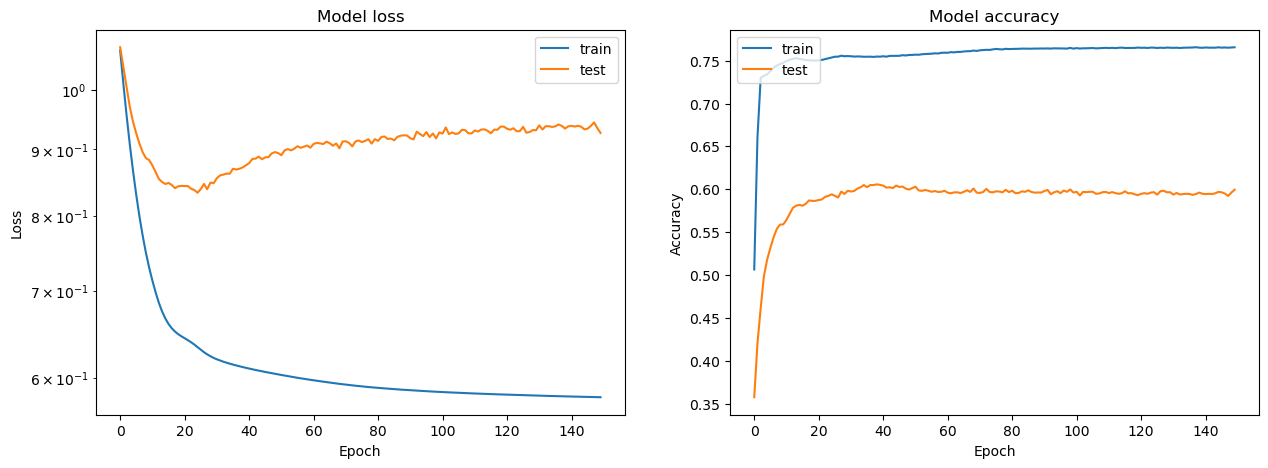

In [5]:
model = models.nn_baseline_model(x_train.shape[1], le.classes_.size, lr=lr)
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_history(history.history)

662/662 [==============================] - 0s 622us/step
[[5101 6856  364]
 [   0  782    3]
 [ 235 1022 6807]]
              precision    recall  f1-score   support

           n       0.96      0.41      0.58     12321
           r       0.09      1.00      0.17       785
           w       0.95      0.84      0.89      8064

    accuracy                           0.60     21170
   macro avg       0.67      0.75      0.55     21170
weighted avg       0.92      0.60      0.68     21170



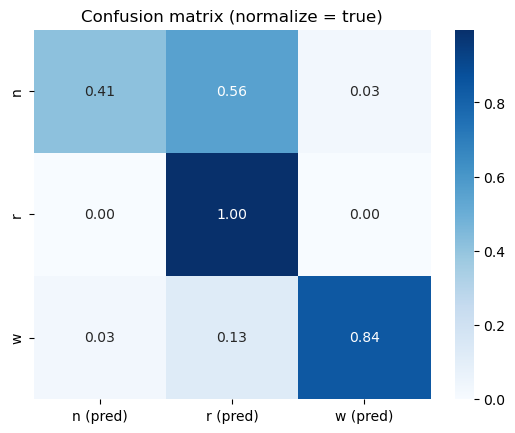

In [6]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

# Random Forest

[[3878 8086  357]
 [   6  777    2]
 [ 445 1070 6549]]
              precision    recall  f1-score   support

           n       0.90      0.31      0.47     12321
           r       0.08      0.99      0.14       785
           w       0.95      0.81      0.87      8064

    accuracy                           0.53     21170
   macro avg       0.64      0.71      0.50     21170
weighted avg       0.89      0.53      0.61     21170



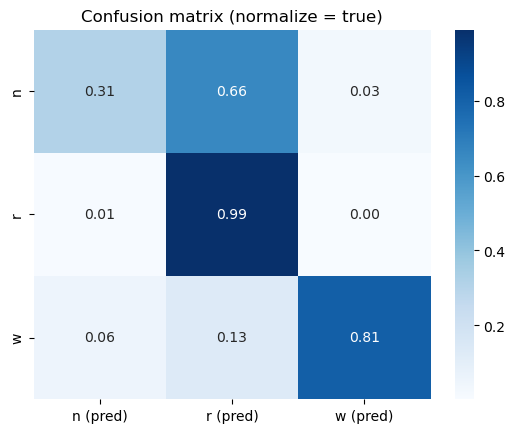

In [7]:
rfc = RandomForestClassifier(random_state=seed)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)
plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')